## 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

### 데이터 전처리

In [4]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/mercari-price-suggestion-challenge/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
# 피처의 타입과 Null 여부 확인하자.

print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


In [6]:
# brand_name 컬럼의 경우 매우 많은 Null 값을 가지고 있다. 전체 1482535건 중에서 849853건이 Not null 이다.
# brand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어 있다.
# category_name은 약 6300건의 null 데이터를 가지고 있다.
# item_description의 null 값은 4건으로 미비하다.

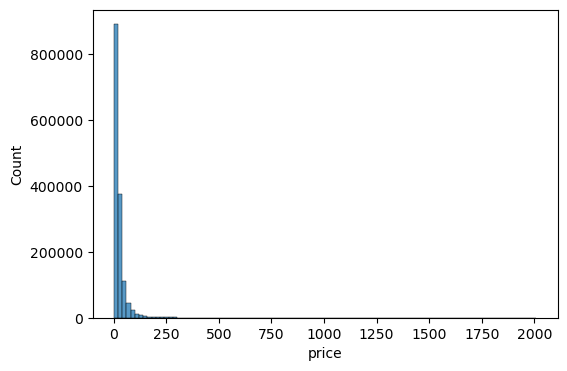

In [7]:
# Target 값인 price 컬럼의 데이터 분포도를 살펴보자. 회귀에서 Target 값의 정규 분포도는 매우 중요하다.
# 왜곡되어 있을 경우 보통 로그 변환을 하면 대부분 정규 분포 형태를 가지게 된다.

import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

In [8]:
# price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포 되어 있다.

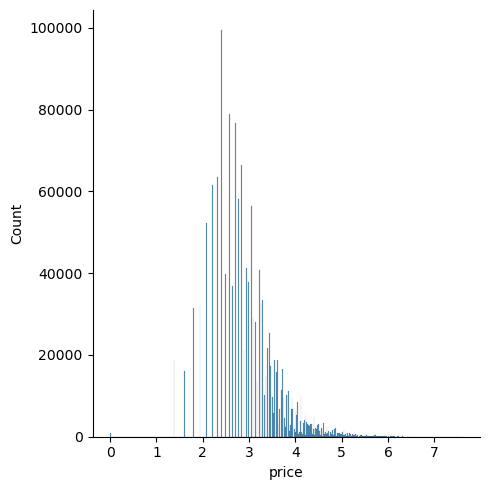

In [9]:
# price 컬럼을 로그 값으로 변환한 뒤 분포도를 다시 살펴보자.
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

In [10]:
# 로그 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다.

In [11]:
# 데이터 세트의 price 컬럼을 원래 값에서 로그로 변환된 값으로 변경하자.
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [13]:
# 다른 피처(shipping, item_condition_id) 값도 살펴보자.

print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\n')
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64


item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [14]:
# Shipping 컬럼은 배송비 유무이며 값이 비교적 균일하다.
# Item_condition_id는 판매자가 제공하는 제품 상태이고, 1,2, 3 값이 주를 이룬다.

# item_description 컬럼은 Null 값은 별로 없지만, description에 대한 별도의 설명이 없는 경우
# 'No description yet' 값으로 돼 있다.

In [15]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [16]:
# 'No description yet'의 경우도 Null과 ㅏ찬가지로 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경해야 한다.
# category_name을 살펴보자. '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다.
# 'Men/Tops/T-shirts'는 대부분 'Men', 중분류 'Tops', 소분류 'T-shirts'로 나눌 수 있다.
# 여기서는 cateogory_name의 '/'를 기준으로 단어를 토큰화해 각각 별도이 피처로 저장하고 이를 이용해 알고리즘을 학습시키자.

# category_name 컬럼을 '/' 기준으로 대, 중, 소분류를 효과적으로 분리해 내기 위해 별도의 split_cat() 함수를 생성하고
# 이를 DataFrame의 apply lambda 식에 적용한다. category_name 컬럼은 Null값을 약 6300여 건을 가지고 있으므로
# 이에 유의하면서 분리를 해내야 한다.
# 파이썬은 문자열에 split(tokenizer문자) 함수를 호출하면 tokenizer 문자에 따라 문자열을 분리해 리스트로 반환한다.
# category_name Null일 경우에는 split() 함수가 Error를 발생하므로 이 Error를 except catch하여 대,중,소 분류로
# 모두 'Other Null' 값을 부여한다.

In [17]:
# apply lamda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['other_null', 'other_null', 'Other_null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대, 중, 소 컬럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수:', mercari_df['cat_jung'].nunique())
print('소분류 갯수:', mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
other_null                  6327
Name: cat_dae, dtype: int64
중분류 갯수: 114
소분류 갯수: 871


In [20]:
# brand_name은 price 값 결정에 영향을 많이 줄 것으로 판단되지만, Null값이 매우 많다.
# 아쉽게도 이 Null 값을 다른 값으로 변경하는 것은 적절하지 않을 것으로 판단되므로
# 일괄적으로 'Other Null'로 변경하자.

# fillna()를 적용한 뒤에 각 컬럼별로 Null값이 없는지 다음과 가이 mercari_df.isnull().sum()을 호출해
# 확인하면 모든 컬럼에서 Null 건수가 0임을 알 수 있다.

In [21]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [22]:
# 데이터 클렌징 작업은 이정도 수준까지만 진행한다.
# 다음은 컬럼을 숫자형 코드 값으로 인코딩하고, 텍스트형 컬럼에 대해서는 피처 벡터화 변환을 적용한다.

### 피처 인코딩과 피처 벡터화 

In [23]:
# 이 피처를 어떤 방식으로 변환할지 검토한 후에 추후에 일괄적으로 전체 속성의 변환 작업을 적용하자.
# Mercari Price Suggestion에서 예측 모델은 price 값(상품 가격)을 예측해야 하므로 회귀 모델을 기반으로 한다.
# 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이며, 특히 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로
# 인코딩할 피처는 모두 원-핫 인코딩을 적용한다. 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를,
# 긴 텍스트는 TD-IDF 기반의 벡터화를 적용한다.

In [24]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name samples 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 11
brand name samples 5건: 
 Women          664385
Beauty         207828
Kids           171689
Electronics    122690
Men             93680
Name: brand_name, dtype: int64


In [26]:
# brand_name의 경우 대부분 명로한 문자열로 되어 있다. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 된다.

print('name 의 종류 갯수:', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name 의 종류 갯수: 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [27]:
# Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있으므로 Count 기반으로 피처 벡터화 변환을 적용한다.
# shipping 컬럼은 배송비 무료 여부로서 0과 1, 두 가지 유형의 값을 가지고 있으며,
# item_condition_id는 상품 상태로서 1,2,3,4,5의 다섯 가지 유형의 값을 가지고 있다.
# item_description은 상품에 대한 간단한 설명으로 데이터 세트에서 가장 긴 텍스트를 가지고 있다.

In [28]:
# 해당 컬럼의 평균 문자열 크기와 2개 정도의 텍스트만 추출 해보자.
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [31]:
# 평균 문자열이 145자로 비교적 크므로 해당 컬럼은 TF-IDF로 변환한다.
# 주요 컬럼을 인코딩 및 피처 벡터화 변환 해보자.

# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_desription에 대한 feature vectorization 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1, 3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [32]:
# CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태이다.
# 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고,
# X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성 되어야 한다.

# 이를 위해서 이 인코딩 대상 컬럼도 밀집 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 한다.
# 사이킷런은 원-핫 인코딩을 위해 OneHotEncoder와 LabelBinarizer 클래스를 제공한다.
# 이 중 LabelBinarizer 클래스는 희소 행려 형태의 원-핫 인코딩 변환을 지원한다.
# 생성 시 sparse_cout=True로 파라미터를 설정해주기만 하면 된다.

# 개별 컬럼으로 만들어진 희소 행렬을 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합한다.

In [33]:
# 인코딩 대상 컬럼을 모두 LabelBinarizer로 원-핫 인코딩 변환한다.

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들은 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [34]:
# 제대로 변환되었는지 생성된 인코딩 데이터 세트의 타입과 shape를 살펴보자.

print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 11), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [35]:
# 인코딩 변화된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입이다.
# 인코딩 컬럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의
# 매우 많은 컬럼과 함께 결합되므로 크게 문제 될 것은 없다.

In [40]:
# 이번에는 앞에서 피처 벡터화 변환된 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합해보자.

from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 잉요하여 앞에서 인코딩과 Vectorization을 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 156770)


778

In [41]:
# hstack()으로 결합한 데이터 세트는 car_matrix 타입이며, 총 156770개의 피처를 가지고 있다.

### 릿지 회귀 모델 구축 및 평가 

In [42]:
# 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것이므로 필요한 로직을 함수화 한다.
# 먼저 모델을 평가하는 평가(Evaluation) 로직을 함수화 한다. RMSLE(Root Mean Square Logarithmic Error) 방식으로 한다.
# 한 가지 주의해야 할 사항은 원본 데이터의 price 컬럼 값은 왜곡된 데이터 분포를 가지고 있기 때문에
# 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환한다.

In [53]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [54]:
# 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직을 별도의 함수로 만들자.

import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

In [55]:
# 먼저 Ridge를 이용해 Mercari Price의 회귀 예측을 수행하자.

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5097080932305015
Item Description을 포함한 rmsle 값: 0.47683017035105524


In [56]:
# Item Description을 포함했 을 때 RMSLE 값이 많이 감소했다. Item description 영향이 중요함을 알 수 있다.

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가 

In [58]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM과 Ridge를 앙상블 한 최종 RMSLE 값:', evaluate_org_price(y_teset, lgbm_preds))

LightGBM과 Ridge를 앙상블 한 최종 RMSLE 값: 0.473274665718866
